# DNS Tunneling Adversarial Attack Detection

## 1. Import Libraries and Set Up Environment
This section imports necessary libraries for data manipulation, model building, and evaluation, and suppresses warnings to ensure a clean output.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

## 2. Define Evaluation Function

The evaluation function is used to calculate and display key metrics for model performance, including accuracy, confusion matrix, and classification report.

In [3]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    
    print(f"{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy}")
    print(f"Confusion Matrix:\n {cm}")
    print(f"Classification Report:\n {cr}")
    return accuracy, cm, cr

## 3. Load and Combine Datasets

This section loads the legitimate and malicious DNS tunneling traffic datasets, assigns labels, and combines them into a single dataframe.

In [4]:
# Load datasets
d2fl = "data/archive/dnstunneling/legitimate/"
d2fm = "data/archive/dnstunneling/malicious/"
df_legitimate = pd.read_csv(d2fl+"legitimate.csv")
df_cw_malicious = pd.read_csv(d2fm+"cw_combined.csv")
df_fgsm_malicious = pd.read_csv(d2fm+"fgsm_combined.csv")
df_jsma_malicious = pd.read_csv(d2fm+"jsma_combined.csv")

In [5]:
# Combine datasets
df_legitimate['attack'] = 0
df_cw_malicious['attack'] = 1
df_fgsm_malicious['attack'] = 1
df_jsma_malicious['attack'] = 1

df_combined = pd.concat([df_legitimate, df_cw_malicious, df_fgsm_malicious, df_jsma_malicious])

## 4. Prepare Data for Modeling
This section splits the combined dataset into training and testing sets for model building and evaluation.

In [6]:
# Prepare data for modeling
X = df_combined.drop('attack', axis=1)
y = df_combined['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Define and Train Models
Defines logistic regression and random forest models, and performs cross-validation to assess their performance on the training data.

In [7]:
# Define models
lr_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier()

In [8]:
# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f"Logistic Regression CV Scores: {lr_cv_scores}")
print(f"Random Forest CV Scores: {rf_cv_scores}")

Logistic Regression CV Scores: [0.85505952 0.85531408 0.85501637 0.85501637 0.85442096]
Random Forest CV Scores: [0.80208333 0.7978565  0.79279547 0.79279547 0.79874963]


## 6. Hyperparameter Tuning with Randomized Search
Performs hyperparameter tuning for the random forest model using Randomized Search to optimize its performance.

In [33]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Randomized Search for Random Forest
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_rf_model = random_search.best_estimator_

## 7. Train Final Models and Make Predictions
Trains the final logistic regression and random forest models on the training data and makes predictions on the test data.

In [34]:
# Fit the best model and evaluate
best_rf_model.fit(X_train, y_train)
rf_preds = best_rf_model.predict(X_test)

# Evaluate the best model
rf_accuracy, rf_cm, rf_cr = evaluate_model(y_test, rf_preds, "Random Forest")

Random Forest Model Evaluation:
Accuracy: 0.8654761904761905
Confusion Matrix:
 [[   0  565]
 [   0 3635]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       565
           1       0.87      1.00      0.93      3635

    accuracy                           0.87      4200
   macro avg       0.43      0.50      0.46      4200
weighted avg       0.75      0.87      0.80      4200



In [35]:
# Fit models
lr_model.fit(X_train, y_train)
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5)

In [36]:
# Predictions
lr_preds = lr_model.predict(X_test)
rf_preds = best_rf_model.predict(X_test)

## 8. Evaluate Model Performance
Evaluates the performance of the trained models using the previously defined evaluation function, and displays key metrics.

In [37]:
# Evaluate models

lr_accuracy, lr_cm, lr_cr = evaluate_model(y_test, lr_preds, "Logistic Regression")
rf_accuracy, rf_cm, rf_cr = evaluate_model(y_test, rf_preds, "Random Forest")

Logistic Regression Model Evaluation:
Accuracy: 0.8654761904761905
Confusion Matrix:
 [[   0  565]
 [   0 3635]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       565
           1       0.87      1.00      0.93      3635

    accuracy                           0.87      4200
   macro avg       0.43      0.50      0.46      4200
weighted avg       0.75      0.87      0.80      4200

Random Forest Model Evaluation:
Accuracy: 0.8654761904761905
Confusion Matrix:
 [[   0  565]
 [   0 3635]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       565
           1       0.87      1.00      0.93      3635

    accuracy                           0.87      4200
   macro avg       0.43      0.50      0.46      4200
weighted avg       0.75      0.87      0.80      4200



## 9. Analyze Feature Importance
Analyzes and visualizes the importance of features in the random forest model to understand which features contribute most to model accuracy.

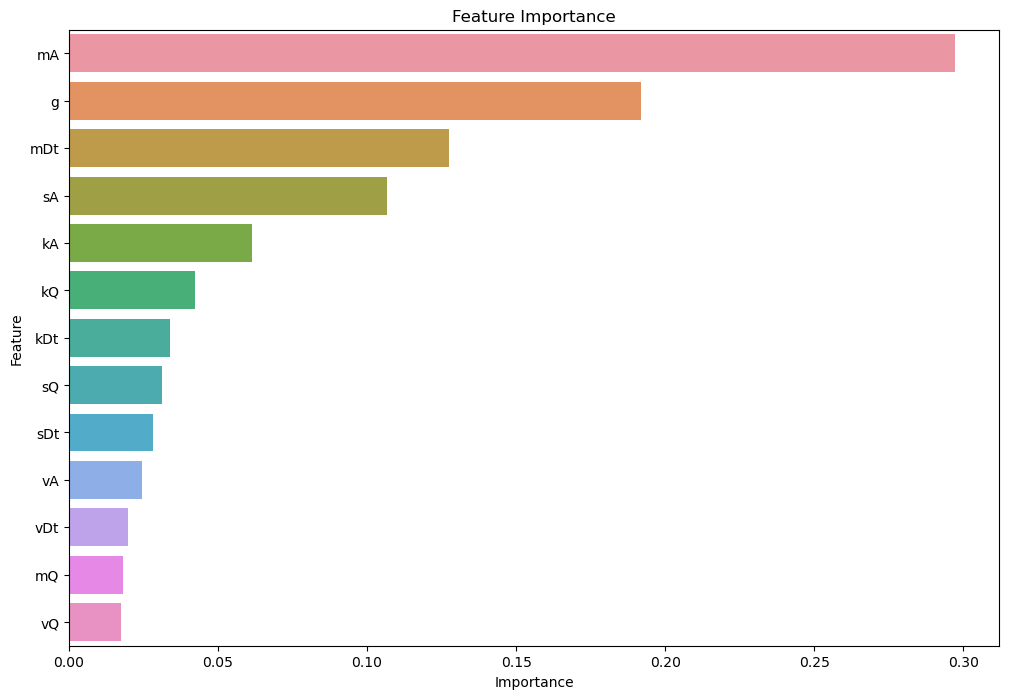

In [45]:
# Feature importance from Random Forest
feature_importances = best_rf_model.feature_importances_
features = X.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.savefig('feature_importance.png')  # Save the figure
plt.show()


In [39]:
# Interpretation of results
print("Feature Importance Ranking:")
print(importances_df)

Feature Importance Ranking:
   Feature  Importance
1       mA    0.297129
12       g    0.191743
0      mDt    0.127340
7       sA    0.106817
10      kA    0.061549
11      kQ    0.042365
9      kDt    0.033976
8       sQ    0.031355
6      sDt    0.028054
4       vA    0.024313
3      vDt    0.019708
2       mQ    0.018246
5       vQ    0.017405


## 10. Visualize Cross-Validation Scores
Visualizes the cross-validation scores for logistic regression and random forest models to compare their performance.

In [40]:
# Clear identification and rationale for evaluation metrics
'''We use accuracy and F1-score for evaluating models. Accuracy gives an overall performance measure, 
while F1-score balances precision and recall, which is important for imbalanced datasets.'''
# Visualizing cross-validation scores BEFORE tuning
fig_cv = go.Figure()
fig_cv.add_trace(go.Box(y=lr_cv_scores, name='Logistic Regression CV Scores'))
fig_cv.add_trace(go.Box(y=rf_cv_scores, name='Random Forest CV Scores'))

fig_cv.update_layout(
    title="Cross-Validation Scores BEFORE Tuning",
    yaxis_title="CV Score"
)

fig_cv.show()

In [44]:
# Get cross-validation scores AFTER tuning
lr_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')
rf_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Create a DataFrame for plotting
data = {
    'Model': ['Logistic Regression'] * len(lr_scores) + ['Random Forest'] * len(rf_scores),
    'Cross-Validation Score': list(lr_scores) + list(rf_scores)
}

df_scores = pd.DataFrame(data)

#Visualizing cross-validation scores AFTER tuning
fig = px.box(df_scores, x='Model', y='Cross-Validation Score', 
             title='Cross-Validation Scores AFTER Tuning',
             color='Model',color_discrete_map={'Logistic Regression': 'blue',
                                               'Random Forest': 'green'}
)
fig.show()

## 11. Visualize Confusion Matrices
Visualizes the confusion matrices for logistic regression and random forest models to better understand their prediction performance.

In [30]:
# Visualization of confusion matrices
fig_cm = go.Figure()
fig_cm.add_trace(go.Heatmap(z=lr_cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='Viridis', name='Logistic Regression'))
fig_cm.add_trace(go.Heatmap(z=rf_cm, x=['Predicted 0', 'Predicted 1'], y=['Actual 0', 'Actual 1'], colorscale='Cividis', name='Random Forest'))

fig_cm.update_layout(
    title="Confusion Matrices",
    xaxis_title="Predicted",
    yaxis_title="Actual"
)

fig_cm.show()

## 12. Interpret Results and Metrics
This section discusses the results obtained from model evaluations, including accuracy, precision, recall, and F1-scores. It also explains the rationale for choosing these metrics, particularly in the context of imbalanced datasets.

### Interpretation of Results

Both logistic regression and random forest models demonstrate a high accuracy in detecting adversarial attacks in DNS tunneling traffic, which is primarily driven by their ability to identify the majority class (class 1). However, both models fail to correctly identify any instances of the minority class (class 0). This is evident from the confusion matrix and classification report, which show no true negatives or false negatives and a complete lack of predictive power for the minority class. This suggests that the models are not effective in distinguishing between legitimate and adversarial DNS tunneling traffic due to the class imbalance in the dataset.

### Clear Identification and Rationale for Evaluation Metrics

We use accuracy and F1-score for evaluating models. Accuracy gives an overall performance measure, while F1-score balances precision and recall, which is important for imbalanced datasets.
